# Description

Runs gaussian mixture model on the z_score_std version of the data.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
INITIAL_RANDOM_STATE = 60000

## Input data

In [6]:
INPUT_SUBSET = "z_score_std"

In [7]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [8]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

## Clustering

In [9]:
from sklearn.mixture import GaussianMixture

In [10]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

In [11]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_MIN"] = 2
CLUSTERING_OPTIONS["K_MAX"] = 60  # sqrt(3749)
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["N_INIT"] = 10
CLUSTERING_OPTIONS["COVARIANCE_TYPE"] = "full"

display(CLUSTERING_OPTIONS)

{'K_MIN': 2,
 'K_MAX': 60,
 'N_REPS_PER_K': 5,
 'N_INIT': 10,
 'COVARIANCE_TYPE': 'full'}

In [12]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in range(CLUSTERING_OPTIONS["K_MIN"], CLUSTERING_OPTIONS["K_MAX"] + 1):
    for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
        clus = GaussianMixture(
            n_components=k,
            n_init=CLUSTERING_OPTIONS["N_INIT"],
            covariance_type=CLUSTERING_OPTIONS["COVARIANCE_TYPE"],
            random_state=random_state,
        )

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        random_state = random_state + 1
        idx = idx + 1

In [13]:
display(len(CLUSTERERS))

295

In [14]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('GaussianMixture #0',
 GaussianMixture(n_components=2, n_init=10, random_state=60000))

('GaussianMixture #1',
 GaussianMixture(n_components=2, n_init=10, random_state=60001))

In [15]:
clustering_method_name = method_name
display(clustering_method_name)

'GaussianMixture'

## Output directory

In [16]:
# output dir for this notebook
RESULTS_DIR = Path(
    conf.RESULTS["CLUSTERING_RUNS_DIR"],
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

# Load input file

In [17]:
data = pd.read_pickle(input_filepath)

In [18]:
data.shape

(3749, 987)

In [19]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.553743,1.851060,-0.095721,0.931603,-0.515196,1.371264,-0.413165,0.729668,0.546338,0.901153,...,1.148776,1.649018,-1.375952,2.203063,0.810199,-0.987048,0.277710,-0.607613,0.572376,-0.660846
100002_raw-Energy,-1.313905,-0.421015,-0.310524,-0.201978,0.233028,0.693838,0.084129,0.572439,0.217866,1.296973,...,0.165430,0.799276,-0.361989,-0.008253,2.063780,-0.930765,-0.147007,1.601938,-0.273553,-0.560822
100003_raw-Protein,-0.645622,-0.997845,0.249039,0.256499,0.422357,0.829189,-0.169004,0.511550,0.002389,-0.057200,...,1.016791,1.019488,-2.148844,-0.065130,0.041052,-0.836118,-0.320571,1.325519,-0.341494,-0.495786
100004_raw-Fat,-0.913924,-1.837183,0.012095,-1.301315,0.205794,1.129114,0.019985,0.376660,-0.810272,0.843611,...,0.544266,0.576714,0.281731,-0.218963,1.258957,-1.131924,0.378545,0.842047,-0.622194,-0.160058
100005_raw-Carbohydrate,-0.523004,0.131379,-0.097802,-0.030526,-0.021500,-0.219116,0.668229,0.365700,1.102347,0.845625,...,-0.344740,0.079274,0.253427,0.236474,1.033895,-0.229105,0.364793,1.776714,0.190531,-1.459641


In [20]:
assert not data.isna().any().any()

# Clustering

## Generate ensemble

In [21]:
from clustering.ensemble import generate_ensemble

In [22]:
ensemble = generate_ensemble(
    data,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

100%|██████████| 295/295 [11:27:50<00:00, 139.90s/it]  


In [23]:
# the number should be close to 295 (the number of partitions generated by k-means/spectral clustering)
ensemble.shape

(295, 3)

In [24]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
GaussianMixture #0,"{'covariance_type': 'full', 'init_params': 'km...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
GaussianMixture #1,"{'covariance_type': 'full', 'init_params': 'km...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
GaussianMixture #2,"{'covariance_type': 'full', 'init_params': 'km...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
GaussianMixture #3,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2
GaussianMixture #4,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2


In [25]:
ensemble["n_clusters"].value_counts().head()

60    5
16    5
28    5
27    5
26    5
Name: n_clusters, dtype: int64

In [26]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    295.000000
mean      31.000000
std       17.058323
min        2.000000
25%       16.000000
50%       31.000000
75%       46.000000
max       60.000000
Name: n_clusters, dtype: float64

## Testing

In [27]:
assert ensemble_stats["min"] > 1

In [28]:
assert not ensemble["n_clusters"].isna().any()

In [29]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [30]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [31]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

## Save

In [32]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores/GaussianMixture-COVARIANCE_TYPE_full-K_MAX_60-K_MIN_2-N_INIT_10-N_REPS_PER_K_5.pkl')

In [33]:
ensemble.to_pickle(output_filename)

# Stability

## Group ensemble by n_clusters

In [34]:
parts = ensemble.groupby("n_clusters").apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [35]:
parts.head()

n_clusters
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...
4    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
5    [[3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0,...
6    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0, 1.0, 1.0,...
dtype: object

In [36]:
assert np.all(
    [
        parts.loc[k].shape == (CLUSTERING_OPTIONS["N_REPS_PER_K"], data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [37]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import squareform, pdist

In [38]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="k"
)

In [39]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

2     1.000000
3     1.000000
4     0.706709
6     0.654032
5     0.562892
7     0.198969
8     0.158953
9     0.156636
10    0.120957
13    0.102207
12    0.101988
11    0.100751
22    0.090791
14    0.090578
52    0.087660
Name: k, dtype: float64

In [40]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)

In [41]:
parts_ari_df.shape

(59, 10)

In [42]:
assert (
    int(
        (CLUSTERING_OPTIONS["N_REPS_PER_K"] * (CLUSTERING_OPTIONS["N_REPS_PER_K"] - 1))
        / 2
    )
    == parts_ari_df.shape[1]
)

In [43]:
parts_ari_df.head()

,0,1,2,3,4,5,6,7,8,9
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.316450,0.300467,0.312368,0.316450,0.951973,0.978283,1.000000,0.960844,0.951973,0.978283
5,0.255985,0.302420,0.307365,0.257242,0.688087,0.623300,0.989519,0.885976,0.692109,0.626916
6,0.170649,0.963083,0.962127,0.966082,0.168698,0.168155,0.168616,0.995114,0.989385,0.988413


## Save

In [44]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-stability-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores/GaussianMixture-stability-COVARIANCE_TYPE_full-K_MAX_60-K_MIN_2-N_INIT_10-N_REPS_PER_K_5.pkl')

In [45]:
parts_ari_df.to_pickle(output_filename)

## Stability plot

In [46]:
parts_ari_df_plot = (
    parts_ari_df.stack()
    .reset_index()
    .rename(columns={"level_0": "k", "level_1": "idx", 0: "ari"})
)

In [47]:
parts_ari_df_plot.dtypes

k        int64
idx      int64
ari    float64
dtype: object

In [48]:
parts_ari_df_plot.head()

,k,idx,ari
0,2,0,1.0
1,2,1,1.0
2,2,2,1.0
3,2,3,1.0
4,2,4,1.0


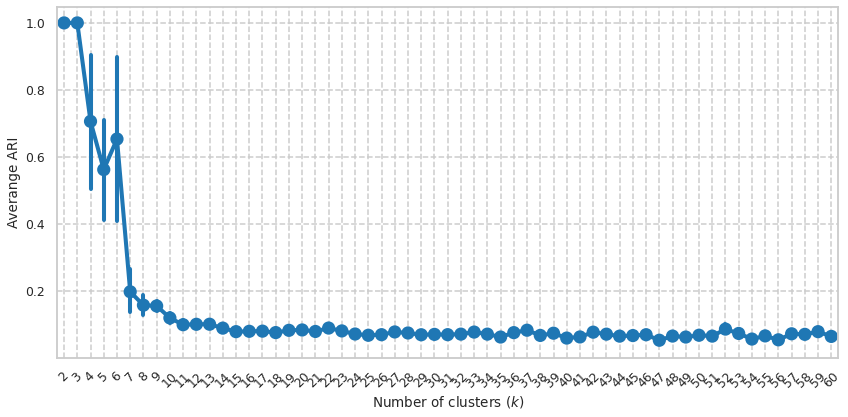

In [49]:
# with sns.axes_style('whitegrid', {'grid.linestyle': '--'}):
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(12, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="k", y="ari")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #     ax.set_ylim(0.0, 1.0)
    #     ax.set_xlim(CLUSTERING_OPTIONS['K_MIN'], CLUSTERING_OPTIONS['K_MAX'])
    plt.grid(True)
    plt.tight_layout()